## Patch Impact Prediction Model

We are going to predict if the patch for servers are going to be risky(1) or safe(0). We have taken some randomly generated data using python. We will test out different models for binary classification and evaluate on different parameters.

### Dataset Summary

| Item                | Description                                                         |
| ------------------- | ------------------------------------------------------------------- |
| **File Name**       | `patch_data_revised.csv`                                            |
| **Total Records**   | 2000                                                                |
| **Total Features**  | 13 (including target)                                               |
| **Prediction Goal** | Predict the `Result` (Safe or Risky) based on pre-patch conditions  |
| **Data Type**       | Mixed — categorical, numerical, and boolean (encoded as Yes/No)     |
| **Leakage Status**  | No post-patch leakage (target derived purely from pre-patch data) |


### Feature Desciption

| Feature Name            | Type                     | Example                                   | Description                                                                                                                                                  |
| ----------------------- | ------------------------ | ----------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Patch_ID**            | *String / ID*            | `P1024`                                   | Unique identifier for each patch record. Used only for reference — should be dropped during modeling.                                                        |
| **OS_Type**             | *Categorical*            | `RHEL`, `Windows`, `Ubuntu`               | Operating system where the patch was applied. Different OS types have varying patch stability characteristics.                                               |
| **Patch_Type**          | *Categorical*            | `Security`, `Bugfix`, `Feature`, `Kernel` | Type of patch. Kernel and Feature patches typically have higher risk compared to Security or Bugfix updates.                                                 |
| **Patch_Severity**      | *Categorical*            | `Low`, `Medium`, `High`, `Critical`       | Describes the severity or importance of the patch, often linked to the scope of change or potential impact.                                                  |
| **Systems_Affected**    | *Numeric (int)*          | `72`                                      | Number of systems affected by the patch rollout. Higher values may imply greater operational risk.                                                           |
| **Server_Usage**        | *Categorical*            | `Low`, `Medium`, `High`                   | Indicates typical workload or resource utilization of the server. High-usage servers are more sensitive to downtime.                                         |
| **Prev_Incidents**      | *Numeric (int)*          | `2`                                       | Number of past patching incidents or failures for this system. Strong predictor of future patch risk.                                                        |
| **Patch_Size_MB**       | *Numeric (int)*          | `340`                                     | Size of the patch in megabytes. Larger patches usually involve more system-level changes, hence higher risk.                                                 |
| **Applied_During_Peak** | *Categorical (Yes/No)*   | `Yes`                                     | Whether the patch was applied during business peak hours. Performing changes during peak hours increases impact potential.                                   |
| **Pre_Health_Score**    | *Numeric (float, 0–100)* | `83.4`                                    | Overall system health before patching, calculated from service, CPU, and disk metrics. Lower scores imply less stability.                                    |
| **Post_Health_Score**   | *Numeric (float, 0–100)* | `78.9`                                    | System health after patching — **used for analysis only**, not for prediction (post-patch metric).                                                           |
| **Downtime_Mins**       | *Numeric (float)*        | `12.6`                                    | Minutes of downtime observed after patching — **used for analysis only**, not for prediction.                                                                |
| **Result**              | *Categorical (Target)*   | `Safe`, `Risky`                           | Target label determined from pre-patch risk score (top 30% riskiest patches labeled as *Risky*, with 15% random noise to mimic real-world unpredictability). |


### Columns to drop for Model Training
| Column              | Reason                                        |
| ------------------- | --------------------------------------------- |
| `Patch_ID`          | Identifier, not predictive.                   |
| `Post_Health_Score` | Post-patch data (not available before patch). |
| `Downtime_Mins`     | Post-patch data (not available before patch). |


## Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Feature selection

In [2]:
#Load dataset
table = pd.read_csv("patch_data_revised.csv")
table.head(5)

,Patch_ID,OS_Type,Patch_Type,Patch_Severity,Systems_Affected,Server_Usage,Prev_Incidents,Patch_Size_MB,Applied_During_Peak,Pre_Health_Score,Post_Health_Score,Downtime_Mins,Result
0,P1000,RHEL,Security,Medium,5,Medium,0,263,No,85.3,83.4,1.3,Safe
1,P1001,Ubuntu,Security,High,55,Medium,0,149,No,73.4,58.9,15.4,Safe
2,P1002,Windows,Kernel,High,9,High,0,50,No,80.3,57.4,12.2,Risky
3,P1003,Windows,Security,Low,17,Low,3,92,No,95.3,79.2,13.1,Risky
4,P1004,RHEL,Security,Low,23,High,0,360,No,74.7,66.5,10.7,Safe


In [3]:
#checking for missing value
table.count()

Patch_ID               2000
OS_Type                2000
Patch_Type             2000
Patch_Severity         2000
Systems_Affected       2000
Server_Usage           2000
Prev_Incidents         2000
Patch_Size_MB          2000
Applied_During_Peak    2000
Pre_Health_Score       2000
Post_Health_Score      2000
Downtime_Mins          2000
Result                 2000
dtype: int64

Since we have generated the dataset ourself we won't have any missing or NaN values. We can proceed to feature selection.

In [4]:
y = table['Result']
X = table.drop(columns=['Patch_ID', 'Result', 'Post_Health_Score', 'Downtime_Mins'], axis=1)

Check the balance of the class:

In [5]:
y.value_counts()

Result
Safe     1292
Risky     708
Name: count, dtype: int64

In [6]:
#mapping result values to their counterparts, since the models works on numerical data only
y = y.map({'Safe':0, 'Risky':1})

In [7]:
y.isna().value_counts()

Result
False    2000
Name: count, dtype: int64

## Splitting the data into training and testing sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Define preprocessing transformers for numerical and categorical features
#### Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features


In [9]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

We will define seperate pipelines for both types:

In [10]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Combine both into column transformer

In [11]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Complete model pipeline

In [12]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]
)

## Optimisation
We'll use the __grid in a cross validation search__ to optimize the model

In [13]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [14]:
# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

## Train the model

Deciding which scoring metric to use:
1. Prioritize Identifying 'Risky' Patches: Since missing a 'Risky' patch (a False Negative) is often more costly than flagging a 'Safe' patch as 'Risky' (a False Positive), the Recall for the 'Risky' class is often a key concern.

2. Use F1-Score: If you want a single, balanced metric, set your scoring to:
scoring='f1'

3. Use ROC-AUC: If you want to evaluate the model's overall discriminative power, use:
scoring='roc_auc'

In [15]:
model = GridSearchCV(estimator=pipeline, cv=cv, param_grid=param_grid, verbose=2, scoring='recall')
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


### Prediction on the unseen data and classification report

In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       258
           1       0.73      0.62      0.67       142

    accuracy                           0.79       400
   macro avg       0.77      0.75      0.76       400
weighted avg       0.78      0.79      0.78       400



### Confusion matrix

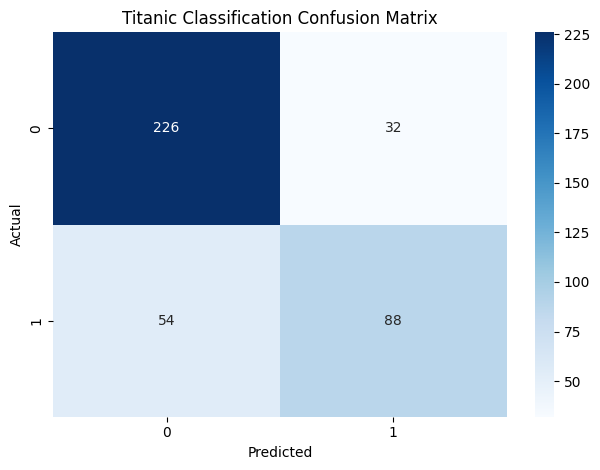

In [17]:
# Enter your code here:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

## Feature importances

In [18]:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['OS_Type_RHEL', 'OS_Type_Ubuntu', 'OS_Type_Windows',
       'Patch_Type_Bugfix', 'Patch_Type_Feature', 'Patch_Type_Kernel',
       'Patch_Type_Security', 'Patch_Severity_Critical',
       'Patch_Severity_High', 'Patch_Severity_Low',
       'Patch_Severity_Medium', 'Server_Usage_High', 'Server_Usage_Low',
       'Server_Usage_Medium', 'Applied_During_Peak_No',
       'Applied_During_Peak_Yes'], dtype=object)

In [19]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

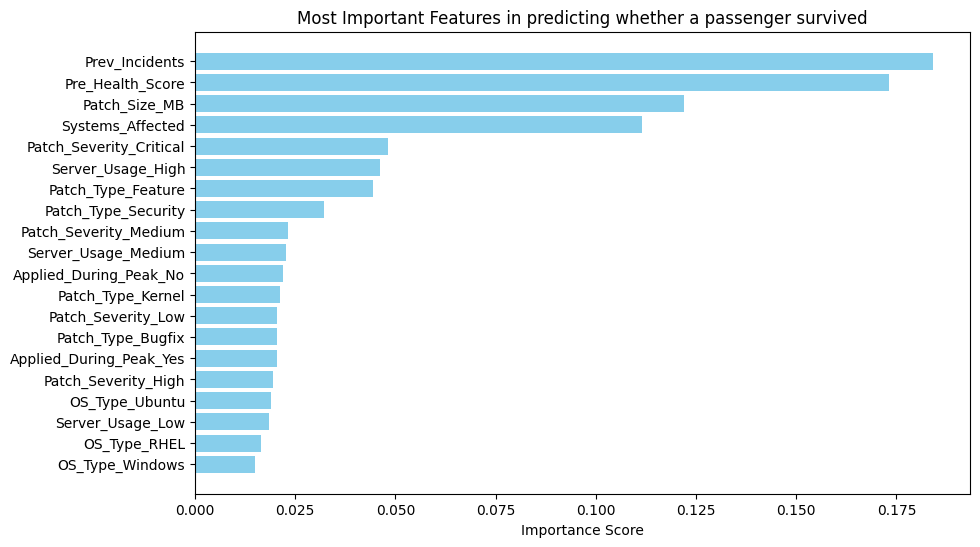


Test set accuracy: 61.97%


In [20]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score 
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

## Let's try Logistic Regression

The model had 100% accuracy. This might be because of correlation, data leakage, or bad data set. Or its just the model performed too much better. Let's check:

In [21]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

In [22]:
# Enter your code here:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       258
           1       0.64      0.70      0.67       142

    accuracy                           0.75       400
   macro avg       0.73      0.74      0.73       400
weighted avg       0.76      0.75      0.75       400



After adding classweight='balanced', still recall of Logistic regression is more. We will try to increase because __cost of False Negative i.e., missed Risky Patch is High__ against __cost of False Positive i.e., False Alarm__. This reasoning is specific to our project. We will tune our threshold and find out which is giving good recall value. Result will be more true Risky patches will be flagged, but more safe patches will gets flagged too. This compromise is necessary for our model otherwise we will lose more risky patches which will increase not only our cost but also more server downtime.

### Threshold Tuning

In [23]:
from sklearn.metrics import recall_score, precision_score
# 1. EXTRACT THE BEST FITTED ESTIMATOR
best_logreg_estimator = model.best_estimator_ 

# Set the positive label for metric calculation (Risky=1)
# Since y_test is already 0/1, we set the target positive class to 1.
POS_LABEL = 1 

# 2. GET PREDICTION PROBABILITIES
# We are interested in the probability of the POSITIVE CLASS (Risky = 1)
# .predict_proba() returns [P(class 0), P(class 1)]. We take column 1.
y_pred_proba = best_logreg_estimator.predict_proba(X_test)[:, POS_LABEL]

# 3. DEFINE THRESHOLDS TO TEST
# We test thresholds below 0.5 to increase recall for the 'Risky' class.
thresholds_to_test = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15]

tuning_results = []
print("\n--- Logistic Regression Threshold Tuning (Optimizing Risky Recall) ---")

for t in thresholds_to_test:
    # Classify patches: Predict 'Risky' (1) if probability >= t, else 'Safe' (0)
    y_pred_t = (y_pred_proba >= t).astype(int)
    
    # Calculate metrics for the 'Risky' class
    # zero_division=0 prevents warnings if no positive predictions are made
    recall = recall_score(y_test, y_pred_t, pos_label=POS_LABEL, zero_division=0)
    precision = precision_score(y_test, y_pred_t, pos_label=POS_LABEL, zero_division=0)
    
    # Calculate the percentage of patches that get flagged as 'Risky'
    perc_risky_pred = np.mean(y_pred_t)
    
    tuning_results.append({
        'Threshold': f"{t:.2f}",
        'Recall (Risky)': f"{recall:.3f}",
        'Precision (Risky)': f"{precision:.3f}",
        'Predicted Risky %': f"{perc_risky_pred*100:.1f}%"
    })

# Print the final analysis table
results_df = pd.DataFrame(tuning_results)
print(results_df.to_string(index=False))



--- Logistic Regression Threshold Tuning (Optimizing Risky Recall) ---
Threshold Recall (Risky) Precision (Risky) Predicted Risky %
     0.50          0.697             0.639             38.8%
     0.45          0.711             0.584             43.2%
     0.40          0.739             0.538             48.8%
     0.35          0.768             0.495             55.0%
     0.30          0.782             0.453             61.3%
     0.25          0.803             0.425             67.0%
     0.20          0.859             0.415             73.5%
     0.15          0.873             0.385             80.5%


#### Few Important Points:
While recall increased, precision took a major hit. Few points to note here:
1. 0.50 Threshold: Recall of 70% (we miss 30% of risky patches).

2. 0.15 Threshold: Recall of 87.3% (we miss ∼13% of risky patches), BUT Precision drops to 38.6%. This means 61.4% of the patches you flag as Risky are actually Safe (false alarms).

But having 61% false alarm means, teams would waste so much time inspecting the systems. This leads to worse resource management which leads to high cost.

__Let us try different model now. XGBoost might be a good call since they are good in capturing complex, non-linear feature interactions.__

## XGBoost Model

In [26]:
from xgboost import XGBClassifier

# Calculate the imbalance weight (assuming y_train is available)
# NOTE: Replace with actual counts if calculated externally
safe_count = y_train.value_counts()[0] 
risky_count = y_train.value_counts()[1]
imbalance_weight = safe_count / risky_count

# Replace the current classifier with XGBoost
# Use the calculated imbalance_weight to bias the model towards the minority class (Risky)
pipeline.set_params(classifier=XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    # CRITICAL: This directly targets imbalance better than class_weight='balanced'
    scale_pos_weight=imbalance_weight 
))

# Update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new, targeted grid for XGBoost (simplified for quick testing)
param_grid = {
    # Test different complexity/depths
    'classifier__max_depth': [3, 5, 7],
    # Test different learning rates (how fast the model learns)
    'classifier__learning_rate': [0.01, 0.1], 
    # Test different regularization (to prevent overfitting)
    'classifier__lambda': [1, 10]
}

model.param_grid = param_grid

# Fit the updated pipeline with XGBoost
print("Fitting XGBoost model...")
model.fit(X_train, y_train)
print("XGBoost fit complete.")
# ----------------------------------------------

print(classification_report(y_test, y_pred))

Fitting XGBoost model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3; total time=   0.6s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3; total time=   0.5s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3; total time=   0.3s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3; total time=   0.2s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3; total time=   0.2s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5; total time=   0.3s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5; total time=   0.2s
[CV] END classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5; total time=   0.3s
[CV] END classifier__lambda=1, classifier__learning_rate=0

### Threshold Tuning for XGBoost

In [27]:
# --- THRESHOLD TUNING FOR XGBOOST ---
# Use the same tuning logic as before on the better-performing model

best_xgb_estimator = model.best_estimator_ 
POS_LABEL = 1 
y_pred_proba = best_xgb_estimator.predict_proba(X_test)[:, POS_LABEL]

# Testing a wider range of thresholds now
thresholds_to_test = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15]

tuning_results = []
print("\n--- XGBoost Threshold Tuning (Optimizing Risky Recall) ---")

for t in thresholds_to_test:
    y_pred_t = (y_pred_proba >= t).astype(int)
    
    recall = recall_score(y_test, y_pred_t, pos_label=POS_LABEL, zero_division=0)
    precision = precision_score(y_test, y_pred_t, pos_label=POS_LABEL, zero_division=0)
    perc_risky_pred = np.mean(y_pred_t)
    
    tuning_results.append({
        'Threshold': f"{t:.2f}",
        'Recall (Risky)': f"{recall:.3f}",
        'Precision (Risky)': f"{precision:.3f}",
        'Predicted Risky %': f"{perc_risky_pred*100:.1f}%"
    })

results_df = pd.DataFrame(tuning_results)
print(results_df.to_string(index=False))

# --- END OF XGBOOST CODE ---



--- XGBoost Threshold Tuning (Optimizing Risky Recall) ---
Threshold Recall (Risky) Precision (Risky) Predicted Risky %
     0.50          0.662             0.653             36.0%
     0.45          0.690             0.601             40.8%
     0.40          0.711             0.546             46.2%
     0.35          0.732             0.488             53.2%
     0.30          0.796             0.469             60.2%
     0.25          0.817             0.439             66.0%
     0.20          0.852             0.402             75.2%
     0.15          0.923             0.376             87.0%


## Conclusion

XGBoost is performing slightly better than Logistic Regression in terms of maintaining precision at higher recall points. __The fundamental issue is not the model, but the quality and clarity of the original data.__